<a href="https://colab.research.google.com/github/ashdev-7/agent-eye/blob/main/ML_Predictive_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predictive Maintenance


In [2]:
# Install required libs (run once)
!pip install --quiet torch torchvision torchaudio
!pip install --quiet pandas numpy scikit-learn matplotlib seaborn


In [ ]:
# to load from google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path('/content/data')  # change if using drive

cols = ['engine_id', 'cycle'] + [f'op_setting_{i}' for i in range(1,4)] + [f'sensor_{i}' for i in range(1,22)]
# load
train = pd.read_csv(DATA_DIR/'train_FD001.txt', sep=r'\s+', header=None, names=cols)
test  = pd.read_csv(DATA_DIR/'test_FD001.txt',  sep=r'\s+', header=None, names=cols)
rul   = pd.read_csv(DATA_DIR/'RUL_FD001.txt', sep=r'\s+', header=None, names=['RUL'])

print('train shape', train.shape)
print('test shape', test.shape)
print('rul shape', rul.shape)


train shape (20631, 26)
test shape (13096, 26)
rul shape (100, 1)


In [6]:
# compute RUL for train (last cycle per engine)
train_max_cycle = train.groupby('engine_id')['cycle'].max().reset_index().rename(columns={'cycle':'max_cycle'})
train = train.merge(train_max_cycle, on='engine_id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop(columns=['max_cycle'], inplace=True)


In [7]:
# attach test RUL: for each engine, the ground truth RUL in rul file corresponds to remaining life after last row in test
test_max_cycle = test.groupby('engine_id')['cycle'].max().reset_index().rename(columns={'cycle':'max_cycle'})
test = test.merge(test_max_cycle, on='engine_id', how='left')
rul['engine_id'] = rul.index + 1
rul.columns = ['RUL','engine_id']

# true remaining cycles after last test point = RUL
test = test.merge(rul, on='engine_id', how='left')
# For evaluation you often need to compute target for sliding windows — we'll handle later.


In [8]:
from sklearn.preprocessing import StandardScaler

sensor_cols = [f'sensor_{i}' for i in range(1,22)]
scaler = StandardScaler()
# fit on training sensor data
train_sensors = train[sensor_cols].values
scaler.fit(train_sensors)

# apply transform function
def transform_df(df):
    arr = scaler.transform(df[sensor_cols].values)
    out = df.copy()
    out[sensor_cols] = arr
    return out

train = transform_df(train)
test  = transform_df(test)


In [9]:
SEQ_LEN = 50  # you can tune: 30, 50, 100 typical values

def make_windows(df, seq_len=SEQ_LEN):
    X, y = [], []
    for engine_id, grp in df.groupby('engine_id'):
        sensors = grp[sensor_cols].values
        rul_series = grp['RUL'].values
        n = len(sensors)
        if n < seq_len:  # skip or pad — we'll skip for simplicity
            continue
        for end in range(seq_len, n+1):
            start = end - seq_len
            X.append(sensors[start:end])            # shape (seq_len, num_sensors)
            y.append(rul_series[end-1])            # RUL at the last timestep
    return np.array(X), np.array(y)

X_train, y_train = make_windows(train, SEQ_LEN)
print('X_train', X_train.shape, 'y_train', y_train.shape)


X_train (15731, 50, 21) y_train (15731,)


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class RULWindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = RULWindowDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class SensorAttentionRUL(nn.Module):
    def __init__(self, num_sensors=21, sensor_emb=64, hidden_dim=128, fc_dim=64):
        super().__init__()
        # Project each sensor scalar into an embedding at each time step
        self.sensor_proj = nn.Linear(1, sensor_emb)  # applied per sensor value
        # sensor attention: compute attention weights over sensors
        self.attn_W = nn.Linear(sensor_emb, 1)  # score per sensor embedding
        # LSTM over time on the attended sensor embedding (now single vector per time)
        self.lstm = nn.LSTM(sensor_emb, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, fc_dim)
        self.fc2 = nn.Linear(fc_dim, 1)

    def forward(self, x):
        # x: (batch, seq_len, num_sensors)
        b, seq_len, num_sensors = x.shape
        # reshape to process each sensor separately: (b*seq_len*num_sensors, 1)
        x_resh = x.view(-1,1)
        emb = self.sensor_proj(x_resh)                    # (b*seq_len*num_sensors, sensor_emb)
        emb = F.relu(emb)
        emb = emb.view(b, seq_len, num_sensors, -1)       # (b, seq_len, num_sensors, sensor_emb)

        # compute attention score per sensor (for each b and t)
        scores = self.attn_W(emb).squeeze(-1)             # (b, seq_len, num_sensors)
        alpha = torch.softmax(scores, dim=-1)             # attention over sensors
        # weighted sum across sensors -> per-time vector
        alpha = alpha.unsqueeze(-1)                       # (b, seq_len, num_sensors, 1)
        attended = (emb * alpha).sum(dim=2)               # (b, seq_len, sensor_emb)

        # LSTM over time
        lstm_out, (h_n,c_n) = self.lstm(attended)         # lstm_out (b, seq_len, hidden_dim)
        # pool over time (mean pooling)
        context = lstm_out.mean(dim=1)                    # (b, hidden_dim)
        z = F.relu(self.fc1(context))
        out = self.fc2(z)                                 # (b,1)
        return out, alpha  # return attention weights for visualization


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SensorAttentionRUL().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

EPOCHS = 30

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred, _ = model(xb)
        loss = criterion(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch {epoch:02d}: train_loss {avg_loss:.4f}')


Epoch 01: train_loss 4866.0403
Epoch 02: train_loss 3272.2108
Epoch 03: train_loss 2756.7805
Epoch 04: train_loss 1598.9424
Epoch 05: train_loss 1392.2848
Epoch 06: train_loss 1244.0524
Epoch 07: train_loss 1149.4118
Epoch 08: train_loss 1038.4097
Epoch 09: train_loss 984.2974
Epoch 10: train_loss 915.5668
Epoch 11: train_loss 904.2231
Epoch 12: train_loss 851.2425
Epoch 13: train_loss 829.9737
Epoch 14: train_loss 790.0204
Epoch 15: train_loss 787.8109
Epoch 16: train_loss 757.5344
Epoch 17: train_loss 726.7506
Epoch 18: train_loss 714.5938
Epoch 19: train_loss 659.5784
Epoch 20: train_loss 633.4198
Epoch 21: train_loss 593.0093
Epoch 22: train_loss 620.3208
Epoch 23: train_loss 530.2379
Epoch 24: train_loss 512.0286
Epoch 25: train_loss 483.8228
Epoch 26: train_loss 439.7311
Epoch 27: train_loss 385.5827
Epoch 28: train_loss 370.5331
Epoch 29: train_loss 347.9898
Epoch 30: train_loss 306.4891


### Testing phase


In [13]:
from sklearn.metrics import mean_squared_error
import math

# --- prepare test windows ---
X_test, y_test = make_windows(test, SEQ_LEN)
test_ds = RULWindowDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

# --- evaluation ---
model.eval()
preds, targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out, _ = model(xb)
        preds.append(out.cpu())
        targets.append(yb.cpu())
preds = torch.cat(preds).numpy().flatten()
targets = torch.cat(targets).numpy().flatten()

rmse = math.sqrt(mean_squared_error(targets, preds))
print(f"Test RMSE: {rmse:.2f}")


Test RMSE: 70.80


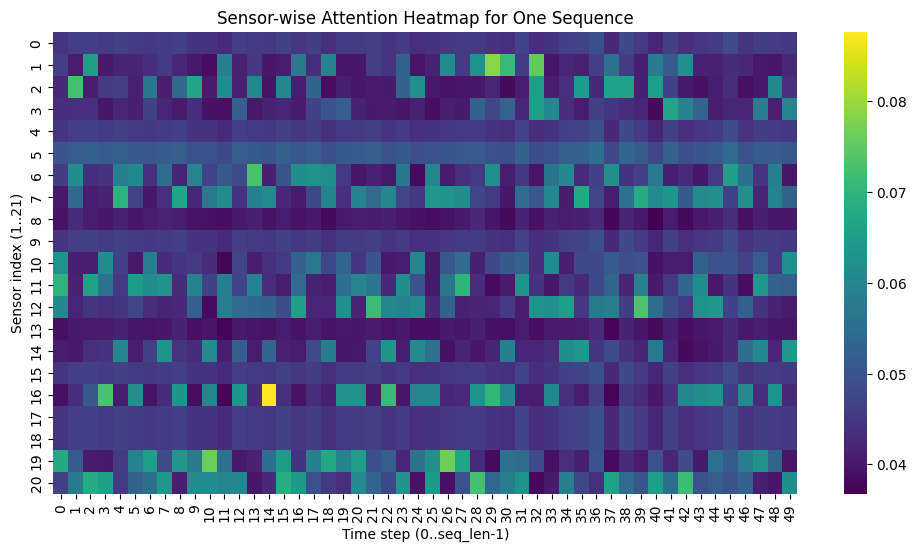

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
xb, yb = next(iter(test_loader))
xb = xb.to(device)
with torch.no_grad():
    pred, alpha = model(xb)   # alpha shape (batch, seq_len, num_sensors, 1)
alpha = alpha.squeeze(-1).cpu().numpy()

sample_idx = 0
plt.figure(figsize=(12,6))
sns.heatmap(alpha[sample_idx].T, cmap="viridis")
plt.xlabel("Time step (0..seq_len-1)")
plt.ylabel("Sensor index (1..21)")
plt.title("Sensor-wise Attention Heatmap for One Sequence")
plt.show()


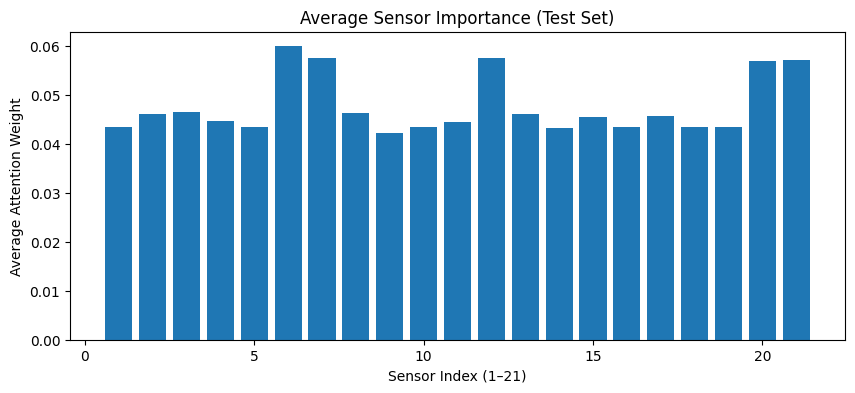

In [15]:
import numpy as np

model.eval()
all_alpha = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        _, alpha = model(xb)
        all_alpha.append(alpha.squeeze(-1).cpu().numpy())

all_alpha = np.concatenate(all_alpha, axis=0)  # (num_samples, seq_len, num_sensors)
mean_alpha = all_alpha.mean(axis=(0,1))  # average over samples and time

plt.figure(figsize=(10,4))
plt.bar(range(1,22), mean_alpha)
plt.xlabel("Sensor Index (1–21)")
plt.ylabel("Average Attention Weight")
plt.title("Average Sensor Importance (Test Set)")
plt.show()
